# Compute hkl0 for a pixel given the following information
* Ei, E, psi

Tricky things
* Make sure Ei is consistent with the beam simulation
* Make sure the angles are in correct units

In [1]:
pwd

u'/SNS/users/p63/notebooks/.rk-work/jnrk-sns-analysis-mcvine-unstable'

In [2]:
# some goodies
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import numpy as np
import histogram.hdf as hh, histogram as H

In [4]:
import mcvine.cli
from mcvine_workflow.DGS import ARCS
from mcvine_workflow import singlextal as sx
from mcvine_workflow.sample import loadSampleYml
from mcvine_workflow.singlextal import io as sxio, coords_transform, dynrange
from mcvine_workflow.singlextal.resolution import use_covmat, use_res_comps

In [5]:
#workdir = '/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/2-fix-pixel-position'
workdir = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/2-fix-pixel-position-v2'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/2-fix-pixel-position-v2


# Inputs

## Instrument

ARCS
* Ei=100
* Fermi chopper: 600 Hz
* T0: 120Hz

In [6]:
instrument = use_covmat.instrument(
    name = 'ARCS',
    detsys_radius = "3.*meter",
    L_m2s = "13.6*meter",
    L_m2fc = "11.61*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_covmat.pixel(
    radius = "0.5*inch",
    height = "meter/128",
    pressure = "10*atm",
    )

## Sample

In [7]:
%%file Si.yml
name: Si
chemical_formula: Si2
lattice: 
 constants: 5.490700041, 5.490700041, 5.490700041, 90, 90, 90
 basis_vectors:
  - 5.490700041, 0, 0
  - 0, 5.490700041, 0
  - 0, 0, 5.490700041
 primitive_basis_vectors:
  - 0.0, 2.71526503565, 2.71526503565
  - 2.71526503565, 0.0, 2.71526503565
  - 2.71526503565, 2.71526503565, 0.0
excitations:
  - type: DGSresolution
orientation:
 u: -1, 1, -1
 v: 2, 1, -1
shape: hollowCylinder in_radius="5./8*inch" out_radius="1.*inch" height="1.5*inch"
temperature: 100*K

Overwriting Si.yml


In [8]:
sample_yml = './Si.yml'

## ** Dynamics parameters

In [9]:
Ei = 100
q = 0
E = 20.  # energy transfer

In [10]:
xo = sxio.loadXtalOriFromSampleYml('Si.yml')
# change psi if needed
xo.psi = np.deg2rad(30.)
print np.rad2deg(xo.psi)

30.0


## Compute hkl0

In [11]:
# coords_transform.rtzE2hkl only takes arrays as input parameters
# so we create some arrays of size 1 here
N = 1  # number of pixels
zs = np.zeros(N) # z of pixels
thetas = np.arange(5., 5.+(N-0.5)*10., 10.) # scattering angles of pixels. unit degree
Es = np.ones(N)*E # energy transfers
rs = np.ones(N)*3. # radius of the cylinder of the det system
print zs
print thetas
print Es

hkl0s = coords_transform.rtzE2hkl(r=rs, theta=np.deg2rad(thetas), z=zs, E=Es, xtalori=xo, Ei=Ei)
hkl0 = hkl0s[0]
print hkl0

[ 0.]
[ 5.]
[ 20.]
[-0.79888382 -0.10818693  0.10818693]


In [12]:
hkl_dir = np.array([0,0,1]) # projection can be changed
hkl = hkl0+q*hkl_dir

In [13]:
print hkl0, hkl_dir, hkl, q, E

[-0.79888382 -0.10818693  0.10818693] [0 0 1] [-0.79888382 -0.10818693  0.10818693] 0 20.0


## ** Other parameters

In [14]:
# scan
class psi_scan:
    min = -5
    max = 90.
    step = 1.

# Dynamic range
**This is optional.** Just to have an idea of the dynamical range

In [15]:
sample = loadSampleYml(sample_yml)
psilist = np.arange(psi_scan.min, psi_scan.max, 5*psi_scan.step)
qaxis = np.arange(-100, 100, .02)

/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/dynrange.py:86: RuntimeWarning: invalid value encountered in arcsin
  phi = np.arcsin(kfv[:, 2], kf)
/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/DGS/ARCS.py:11: RuntimeWarning: invalid value encountered in less
  return ((theta<135.) * (theta > 3.) + (theta < -3)*(theta>-28)) * (phi<26.565) * (phi>-26.565)
/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/DGS/ARCS.py:11: RuntimeWarning: invalid value encountered in greater
  return ((theta<135.) * (theta > 3.) + (theta < -3)*(theta>-28)) * (phi<26.565) * (phi>-26.565)


(-4.8576370515032892, 27.126114945090904)

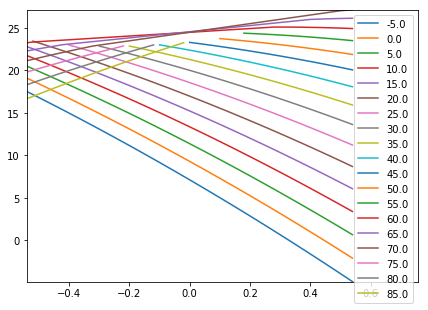

In [16]:
plt.figure(figsize=(7,5))
points_in_slice = list(dynrange.iterPointsInSlice(
        sample, psilist, Ei, hkl0, hkl_dir, qaxis,
        ARCS.scattering_angle_constraints,
        Erange=(-Ei, Ei)))
all_qs = np.concatenate([qs for _p, qs, _E in points_in_slice ])
qmin = np.min(all_qs); qmax = np.max(all_qs)

all_Es = np.concatenate([Es for _p, _q, Es in points_in_slice ])
Emin = np.min(all_Es); Emax = np.max(all_Es)

for psi, qs, Es in points_in_slice:
    plt.plot(qs, Es, label=str(psi))
    continue
    
plt.legend()
plt.xlim(qmin, qmax+(qmax-qmin)/5)
plt.ylim(Emin, Emax)

In [17]:
print hkl

[-0.79888382 -0.10818693  0.10818693]


In [18]:
outdir = 'tmp.use_res_comps'
!rm -rf {outdir}
beam = '/SNS/users/lj7/simulations/ARCS/beam/100meV-n1e10/'
use_res_comps.setup(outdir, sample_yml, beam, E, hkl, hkl_dir, psi_scan, instrument, pixel)

Ei=100.538483519, t0=19.516533925
Computed:
* psi=29.7857729762 degree
* Q=[  7.55020156e-01  -5.44370306e-01  -2.77555756e-17]
* hkl2Qmat=[[ -1.03754027e+00   4.82707535e-01   3.50307614e-17]
 [  3.41325771e-01   7.33651759e-01  -8.09165116e-01]
 [ -3.41325771e-01  -7.33651759e-01  -8.09165116e-01]]
* ki=6.96559982195
* vectors ki=[ 6.96559982  0.          0.        ], kf=[  6.21057967e+00   5.44370306e-01   2.77555756e-17]
These two numbers should be very close:
  20.0
  20.0
  Ei=100.538483519, Ef=80.538483519
* Ef=80.538483519
* pixel positon=[  2.98854165e+00   2.61951930e-01   1.33560309e-17]
* pixel_position=[  2.98854165e+00   2.61951930e-01   1.33560309e-17]
t_m2s=0.00312050823099, t_s2p=0.000764271017914, t_m2p=0.00388477924891


/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/solve_psi.py:55: UserWarning: Traceback (most recent call last):
  File "/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/solve_psi.py", line 52, in solve
    results.append(solver(res, min, max))
  File "/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/scipy/optimize/zeros.py", line 442, in brentq
    r = _zeros._brentq(f,a,b,xtol,rtol,maxiter,args,full_output,disp)
ValueError: f(a) and f(b) must have different signs

  warnings.warn(tb.format_exc())


In [22]:
!pwd
!ls
!ls tmp.use_res_comps/
#ls tmp.use_res_comps/

/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/2-fix-pixel-position-v2
Si.yml	tmp.use_res_comps
run.py	sample


In [23]:
%%time
#%%script bash
#cd tmp.use_res_comps/
#python run.py
%cd tmp.use_res_comps/
!python run.py
%cd {workdir}

/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/2-fix-pixel-position-v2/tmp.use_res_comps
weight:  1.0
0-99999: ........../SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/SimulationContext.py:39: UserWarning: output directory was not set
  warnings.warn("output directory was not set")

100000-199999: ..........
200000-299999: ..........
300000-399999: ..........
400000-499999: ..........
500000-599999: ..........
600000-699999: ..........
700000-799999: ..........
800000-899999: ..........
900000-999999: ..........
1000000-1099999: ..........
1100000-1199999: ..........
1200000-1299999: ..........
1300000-1399999: ..........
1400000-1499999: ..........
1500000-1599999: ..........
1600000-1699999: ..........
1700000-1799999: ..........
1800000-1899999: ..........
1900000-1999999: ..........
2000000-2099999: ..........
2100000-2199999: ..........
2200000-2299999: ..........
2300000-2399999: ..........
2400000-2499999: ..........
250000